In [1]:
library(devtools)
library(cmapR)
library(caret)
library(Amelia)
library(ggbiplot)
library(tidyverse)
library(viridis)
library(binovisualfields)

Loading required package: usethis

Loading required package: lattice

Loading required package: ggplot2

Loading required package: Rcpp

## 
## Amelia II: Multiple Imputation
## (Version 1.7.6, built: 2019-11-24)
## Copyright (C) 2005-2021 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 

Loading required package: plyr

Loading required package: scales

Loading required package: grid

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.5     v dplyr   1.0.3
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::arrange()    masks plyr::arrange()
x readr::col_factor() masks scales::col_factor()
x purrr::compact()    masks plyr::compact()
x dplyr::count()      masks plyr::count()
x purrr::discard()    masks scales::discard()
x dplyr::failwith()   mask

In [2]:
ds_path <- 'PAAD.gct'
my_ds <- parse_gctx(ds_path)

parsing as GCT v1.3

PAAD.gct 18465 rows, 183 cols, 0 row descriptors, 124 col descriptors



In [3]:
# https://www.bioconductor.org/packages/devel/bioc/vignettes/cmapR/inst/doc/tutorial.html
# This contains the gene data of each of the 183 samples
m <- mat(my_ds) # Rows are the features and columns are the observations 

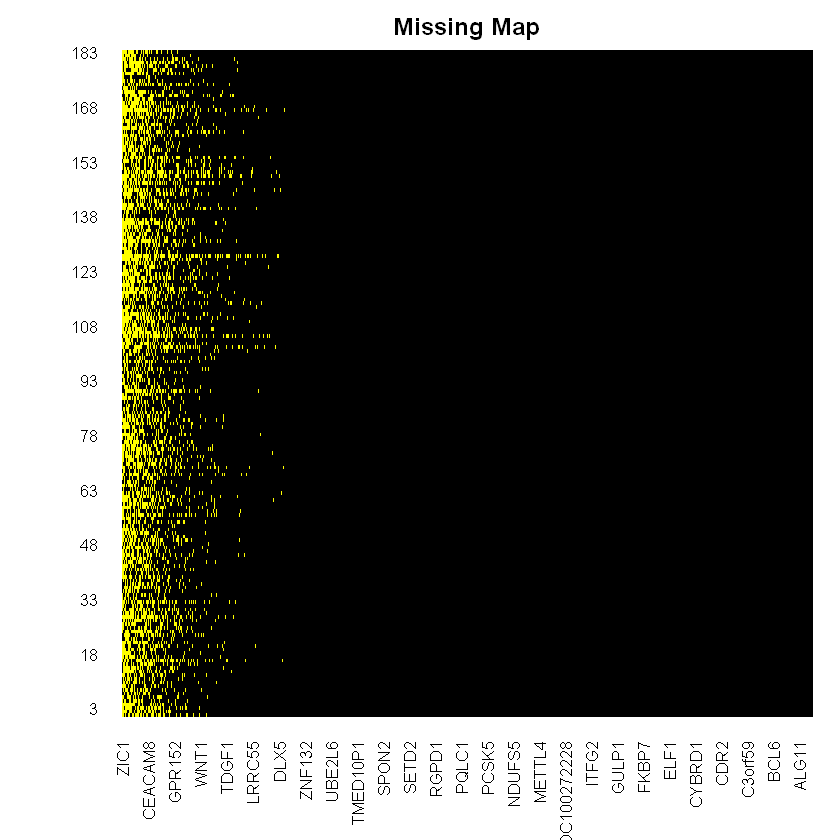

In [4]:
# Get a heat-map of all the missing data
missmap(as.data.frame.matrix(t(m)),main='Missing Map', col=c('yellow','black'), legend= F)

In [5]:
df_na <- as.data.frame.matrix(t(m)) # This contains the original NA values. To be
# used when plotting

In [6]:
# access the row and column metadata
rdesc <- meta(my_ds, dimension = "row")
# This contains the description of each of the 183 samples
cdesc <- meta(my_ds, dimension = "column")
head(cdesc$adenocarcinoma_invasion)

[1] "yes" "yes" "yes" "yes" "yes" "yes"

In [7]:
# access the row and column ids
rid <- ids(my_ds, dimension = "row") # This contains all the gene names
cid <- ids(my_ds, dimension = "column") # This contains all the sample names

In [8]:
# Q1
# PCA
# dropping features containing NA's
df_na_drop_col <- apply(is.na(df_na),2,any) # Find the rows which have NA values,
# and then drop them
df_na_drop <- df_na[,df_na_drop_col==F]
# Perform PCA with this reduced set of features
df_pca_2 <- prcomp(x = df_na_drop,center = T,scale. = T,rank. = 2)
# Get the variance explained by each PC
summary(df_pca_2)
# PC1 accounts for 16.4% of the total variation and 
# PC2 accounts for 11.9% of the total variation, with a cumulative variation of 28.4%

Importance of first k=2 (out of 183) components:
                           PC1     PC2
Standard deviation     48.1279 41.0278
Proportion of Variance  0.1643  0.1194
Cumulative Proportion   0.1643  0.2837

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

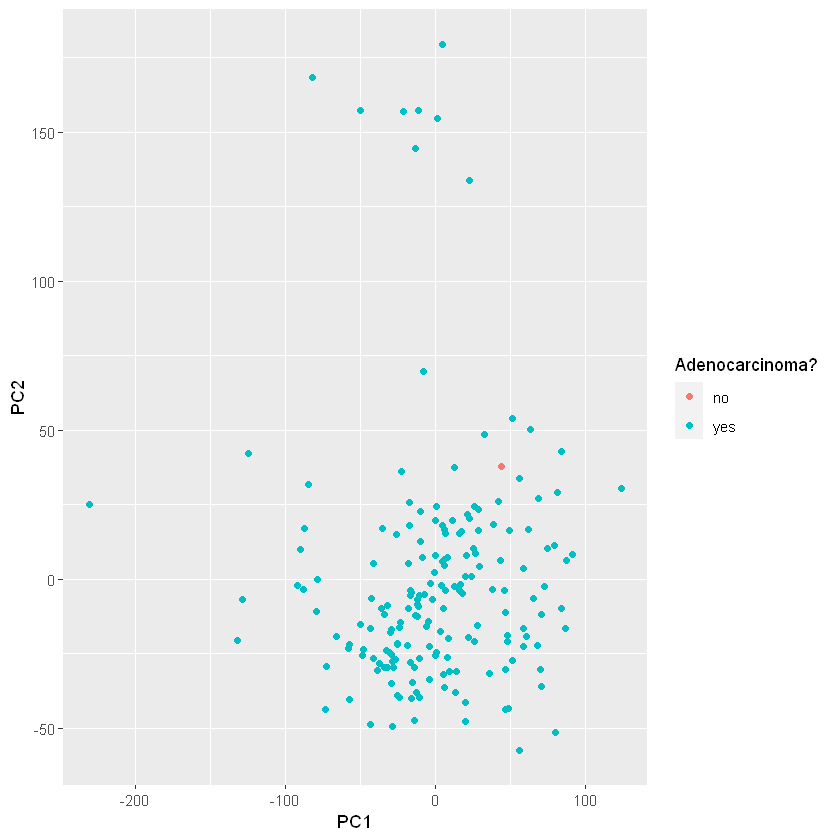

In [9]:
# Transform the points in the original Vector space into the reduced vector space
trans_df_2 <- as.data.frame(predict(object = df_pca_2,newdata = df_na_drop))
# Visualize them
pl <- ggplot(trans_df_2,aes(x=PC1,y=PC2)) +
  geom_point(aes(color = factor(cdesc$adenocarcinoma_invasion)))+
  labs(color='Adenocarcinoma?')
print(pl)
# Most of the points are clustured about a narrow band about PC1 
# The PCA clustering here seems to depict that the '​Neuroendocrine' is away from the large clusters' center. So it does appear to be seperable.

In [10]:
# Drop 'Neuroendocrine tumors'
df_adeno <- df_na_drop[cdesc$adenocarcinoma_invasion=='yes',]

In [11]:
# Q2
# Type 1 IFN help regulate the activity of the immune system. They are active 
# against Tumors
#df_na$IFNAR1 # All type I IFNs bind to a specific cell surface receptor known as 
#df_na$IFNAR2 # the IFN-alpha receptor: IFNAR1 and IFNAR2 https://en.wikipedia.org/wiki/Interferon_type_I
# Type 1 IFN alpha consists of the following
#df_na$IFNA1
#df_na$IFNA13
# No other IFN sub-types are present

Warning message:
"Removed 128 rows containing missing values (geom_point)."


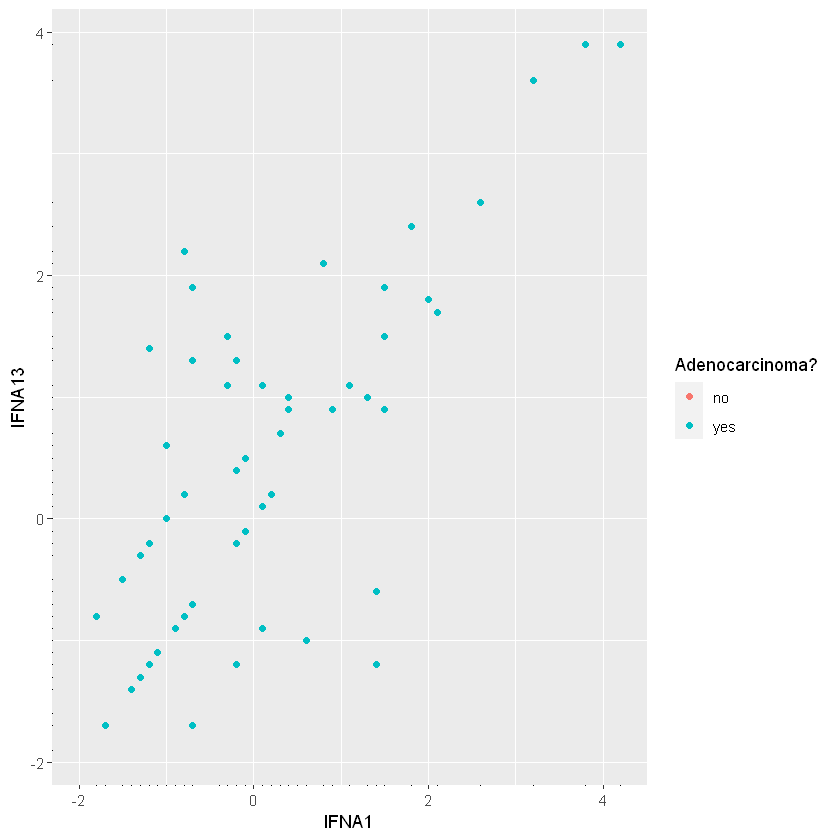

In [12]:
# A scatter-plot of the distribution of the proteins IFNA1' and 'IFNA13' 
pl <- ggplot(df_na,aes(x=IFNA1,y=IFNA13)) +
  geom_point(aes(color=factor(cdesc$adenocarcinoma_invasion))) +
  geom_rug(outside = T)+ labs(color='Adenocarcinoma?')
print(pl)
# Since the features 'IFNA1' and 'IFNA13' express a positive correlation,
# to characterize the presence of 'IFN' signature, we could use their average 
# gene expression values.
# It appears that 'IFNA1' has 128 missing values. Hence, those samples were dropped automatically

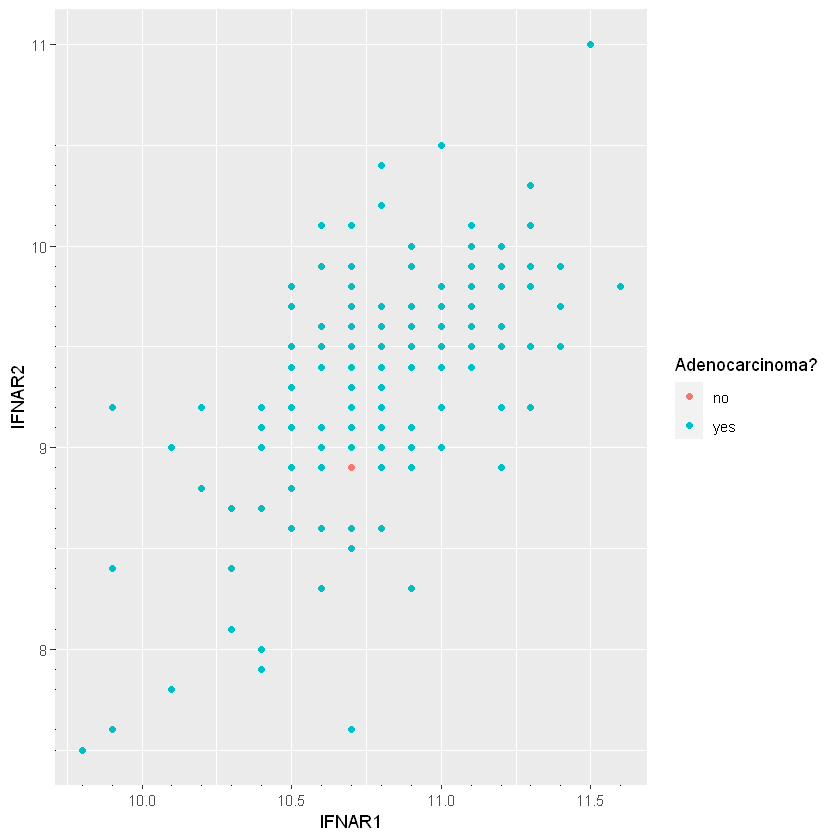

In [13]:
# A scatter-plot of the distribution of the receptors 'IFNAR1' and 'IFNAR2'
pl <- ggplot(df_na,aes(x=IFNAR1,y=IFNAR2)) +
  geom_point(aes(color=factor(cdesc$adenocarcinoma_invasion))) +
  geom_rug(outside = T)
pl2 <- pl+ labs(color='Adenocarcinoma?')
print(pl2)

In [14]:
# Where 'adenocarcinoma' was not present, we have a 'NaN' value
df_na$IFNA1[cdesc$adenocarcinoma_invasion=='no']
df_na$IFNA13[cdesc$adenocarcinoma_invasion=='no']
df_na$IFNAR1[cdesc$adenocarcinoma_invasion=='no']
df_na$IFNAR2[cdesc$adenocarcinoma_invasion=='no']

[1] NaN

[1] NaN

[1] 10.7

[1] 8.9

In [15]:
# Read in the IFN gene list comprising of 25 genes
gene_IFN <- read.delim('type1_IFN.txt')
dim(gene_IFN)

[1] 25  1

In [16]:
# a) Perform GSVA to characterize the presence of IFN signatures
# Use the genes without any NA values soas to avoid the Warning of ' 4367 genes 
# with constant expression values throuhgout the samples.'
gsva_scores <- GSVA::gsva(expr = t(as.matrix.data.frame(df_na_drop)),gset.idx.list = as.list.data.frame(gene_IFN))
gsva_scores <- as.data.frame(t(gsva_scores))
for (i in c(1:24)) {
  print(any(is.na(m[gene_IFN[i,1],])))
  if(any(is.na(m[gene_IFN[i,1],]))==TRUE){
    print(gene_IFN[i,1])
  }
}
# looks like the gene 'IRGM' is missing some data points in the data-set

Estimating GSVA scores for 1 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%

[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] TRUE
[1] "IRGM"
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE


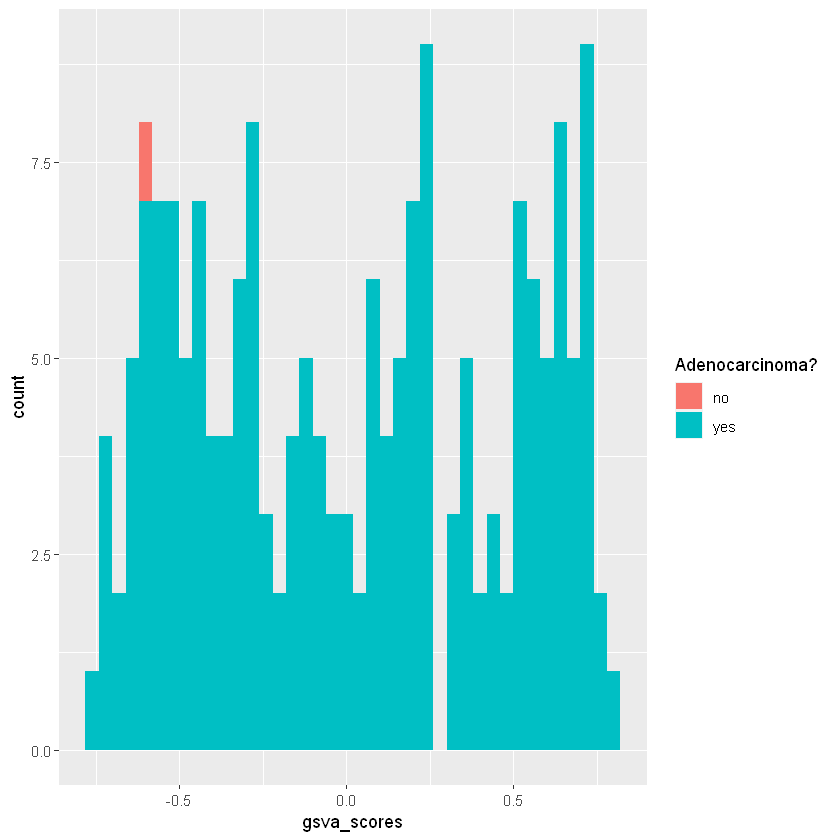

In [17]:
# b) Distribution of the scores
pl <- ggplot(gsva_scores,aes(x=gsva_scores))+
  geom_histogram(aes(fill=factor(cdesc$adenocarcinoma_invasion)),bins=40)+
  labs(fill='Adenocarcinoma?')
print(pl)

In [18]:
# make a Heat map of the values
# Collect the values of the 'GSVA' and the 25 IFN gene expressions
df_1 <- gsva_scores
for (i in c(1:dim_IFN[1])){
  df_1 <- cbind(df_1,df_na[,gene_IFN[i,1]])
}
# Get the current columns
df_1_col <- colnames(df_1)
# Rename the columns (except the 1st one)
for (i in c(1:dim_IFN[1])){
  df_1_col[1+i] <- gene_IFN[i,1]
}
colnames(df_1) <- df_1_col
# Scale the data
# Normalize the data
maxs <- apply(df_1,MARGIN = 2,FUN = max)
mins <- apply(df_1,MARGIN = 2,FUN = min)
df_1_scaled <- as.data.frame(scale(df_1,center = mins,scale = (maxs-mins)))
# Structure the data
dt2 <- df_1_scaled %>%
  rownames_to_column() %>%
  gather(colname, value, -rowname)
head(dt2)

,rowname,colname,value
,<chr>,<chr>,<dbl>
1,aab1-Primary solid Tumor,gsva_scores,0.7514381
2,aab4-Primary solid Tumor,gsva_scores,0.9171162
3,aab6-Primary solid Tumor,gsva_scores,0.9418691
4,aab8-Primary solid Tumor,gsva_scores,0.8523268
5,aab9-Primary solid Tumor,gsva_scores,0.1272855
6,aaba-Primary solid Tumor,gsva_scores,0.0628874


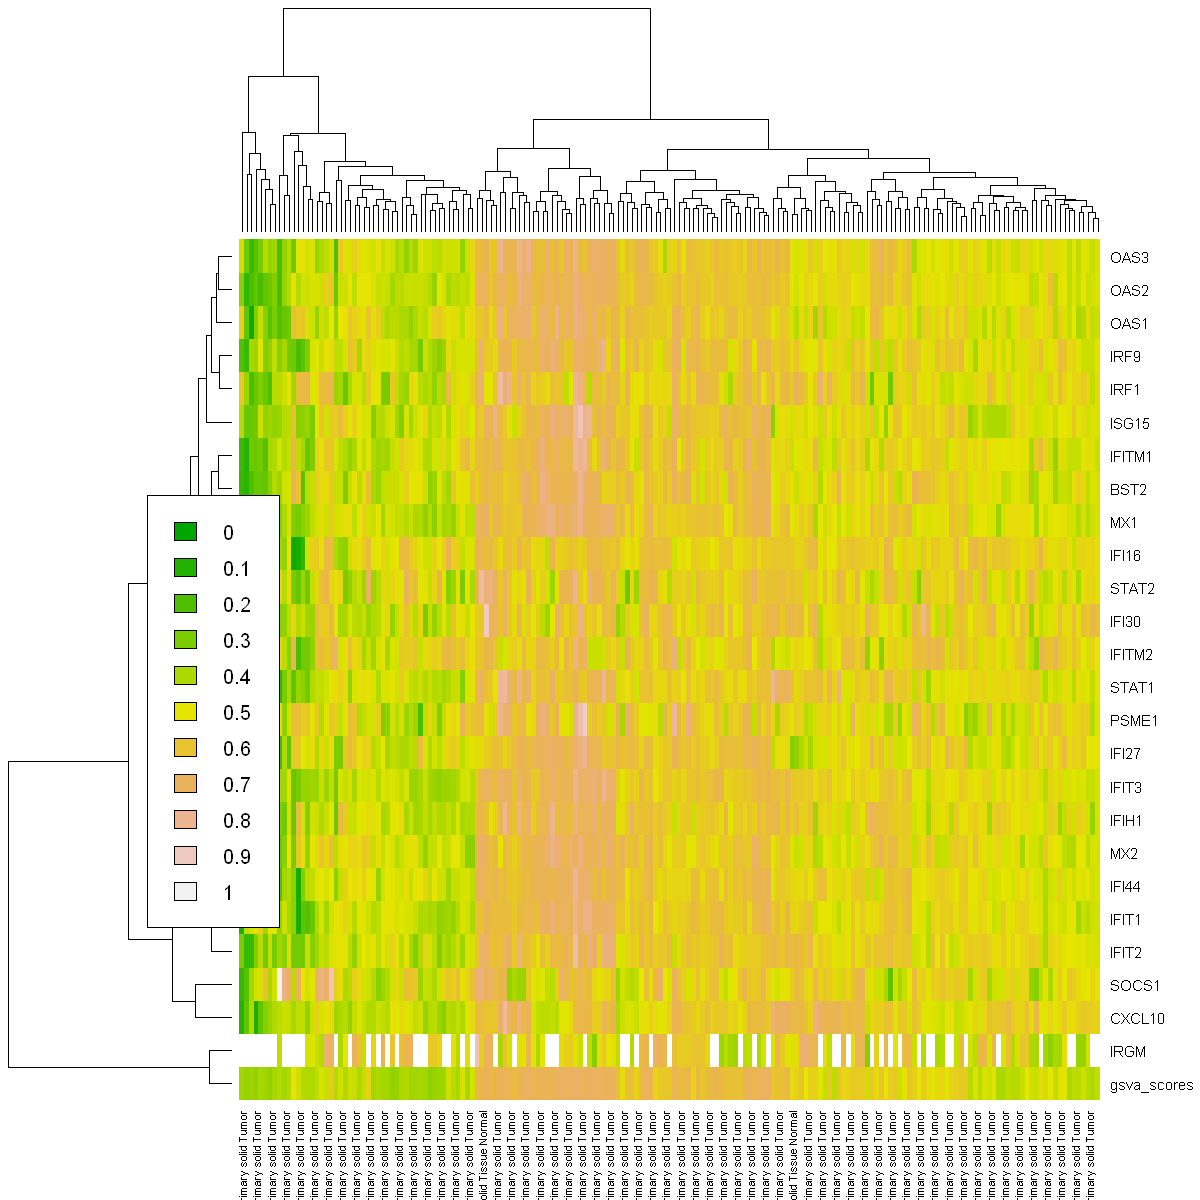

In [98]:
# Plot heat map
heatmap(t(as.matrix.data.frame(df_1)), scale="row", col = terrain.colors(256))
legend(x=0,y=0.6, legend=seq(from = 0,to = 1,by = 0.1),fill=colorRampPalette(colors = terrain.colors(256))(11))
# c) From the heat-map, there seems to be a strong correlation between GSVA score and the IFN subtypes

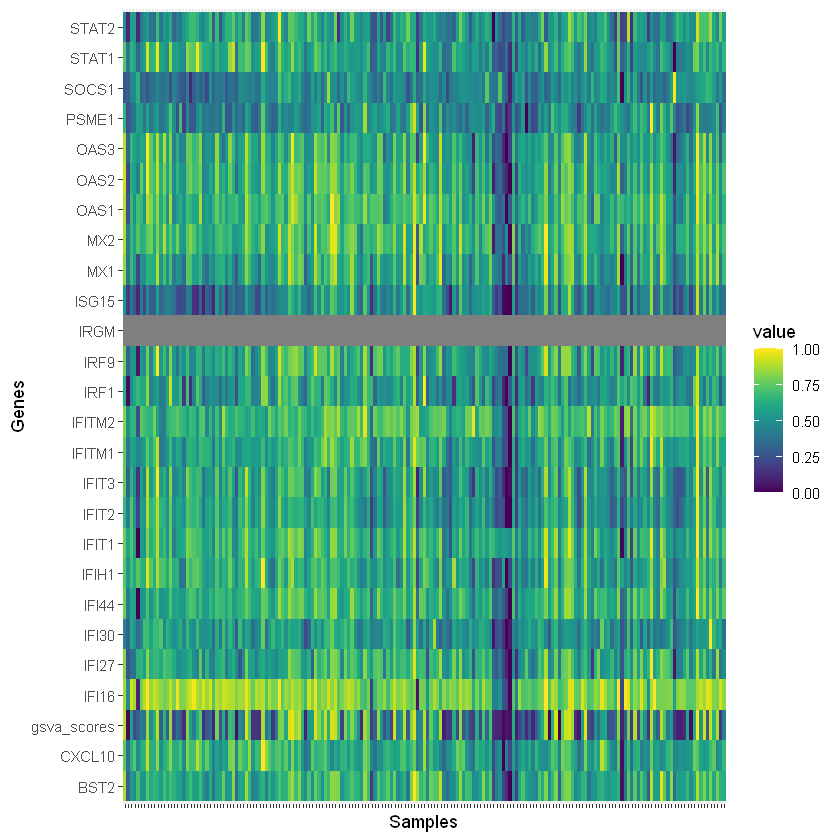

In [20]:
pl <- ggplot(dt2, aes(x = rowname, y = colname, fill = value)) + geom_tile(stat = )+ 
  scale_fill_viridis(discrete=FALSE)+
  theme(axis.text.x = element_blank())+xlab(label = 'Samples')+ylab(label = 'Genes')
print(pl)

Warning message:
"Removed 1 rows containing missing values (position_stack)."


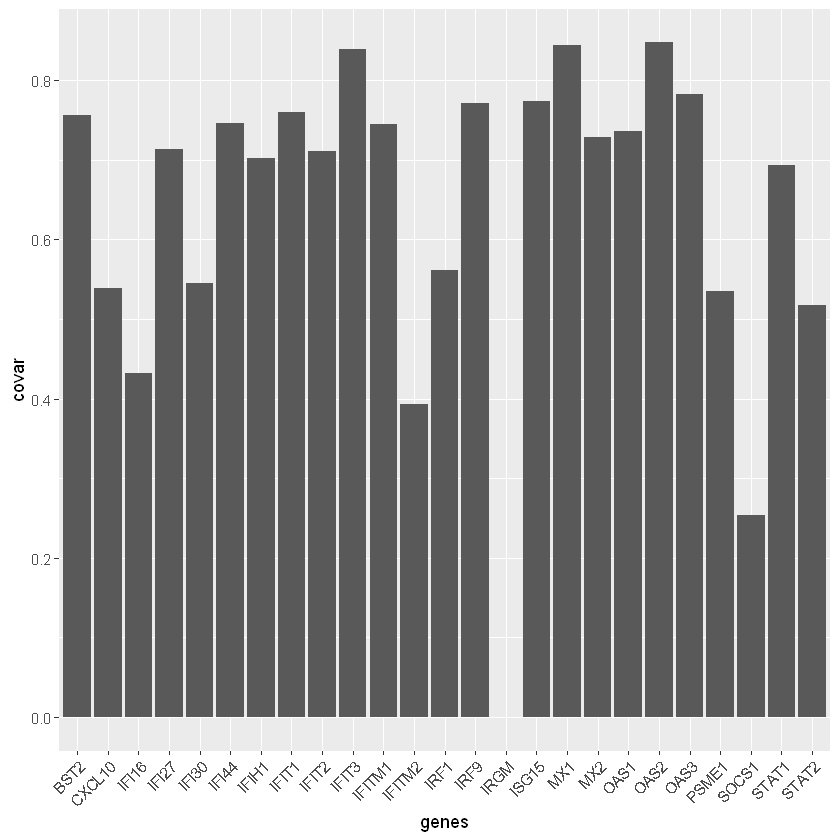

In [21]:
# To quantify the extent to which the expression of the 25 genes are correlated
# to the GSVA score, we calculate their covariance
# Covariance
dim_df_1_scaled <- dim(df_1_scaled)
covar <- vector()
gsva_mean_score <- mean(df_1_scaled$gsva_scores)
gsva_std <- sd(df_1_scaled$gsva_scores)
for (i in c(1:dim_IFN[1])){
  corr <-sum((df_1_scaled$gsva_scores-gsva_mean_score)*(df_1_scaled[,i+1]-mean(df_1_scaled[,i+1])))
  covar <- c(covar,corr/(gsva_std*sd(df_1_scaled[,i+1])*(dim_df_1_scaled[1]-1)))
}
covar <- data.frame(covar)
covar <- cbind(covar,df_1_col[-1])
colnames(covar) <- c('covar','genes')
# Bar plot
pl <- ggplot(covar,aes(x=genes,y=covar))+geom_bar(stat = "identity")+
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
print(pl)

In [22]:
# Verifying the presence of Genes for identifying cytolytic activity. 
# The cytolytic-low tumors exhibited a slight increase in the number of mutations per tumor compared with cytolytic-high tumors
head(df_na_drop$GZMA) # Source: https://ar.iiarjournals.org/content/38/12/6631#:~:text=Abstract,the%20CYT%20score%20in%20HCC.
head(df_na_drop$PRF1)

[1] 7.4 6.1 3.9 6.2 6.6 6.4

[1] 7.3 7.2 5.6 6.8 6.8 6.6

In [37]:
# Observe effects of cytolytic activity
df_cyto <- data.frame(cbind(df_na_drop$GZMA,df_na_drop$PRF1))
colnames(df_cyto) <- c('GZMA','PRF1')
rownames(df_cyto) <- cid
# Generate heat map
# Scale the data and Normalize the data
maxs <- apply(df_cyto,MARGIN = 2,FUN = max)
mins <- apply(df_cyto,MARGIN = 2,FUN = min)
df_cyto_scaled <- as.data.frame(scale(df_cyto,center = mins,scale = (maxs-mins)))
# Structure the data
dt2 <- df_cyto_scaled %>%
  rownames_to_column() %>%
  gather(colname, value, -rowname)
head(dt2)

,rowname,colname,value
,<chr>,<chr>,<dbl>
1,aab1-Primary solid Tumor,GZMA,0.6805556
2,aab4-Primary solid Tumor,GZMA,0.5000000
3,aab6-Primary solid Tumor,GZMA,0.1944444
4,aab8-Primary solid Tumor,GZMA,0.5138889
5,aab9-Primary solid Tumor,GZMA,0.5694444
6,aaba-Primary solid Tumor,GZMA,0.5416667


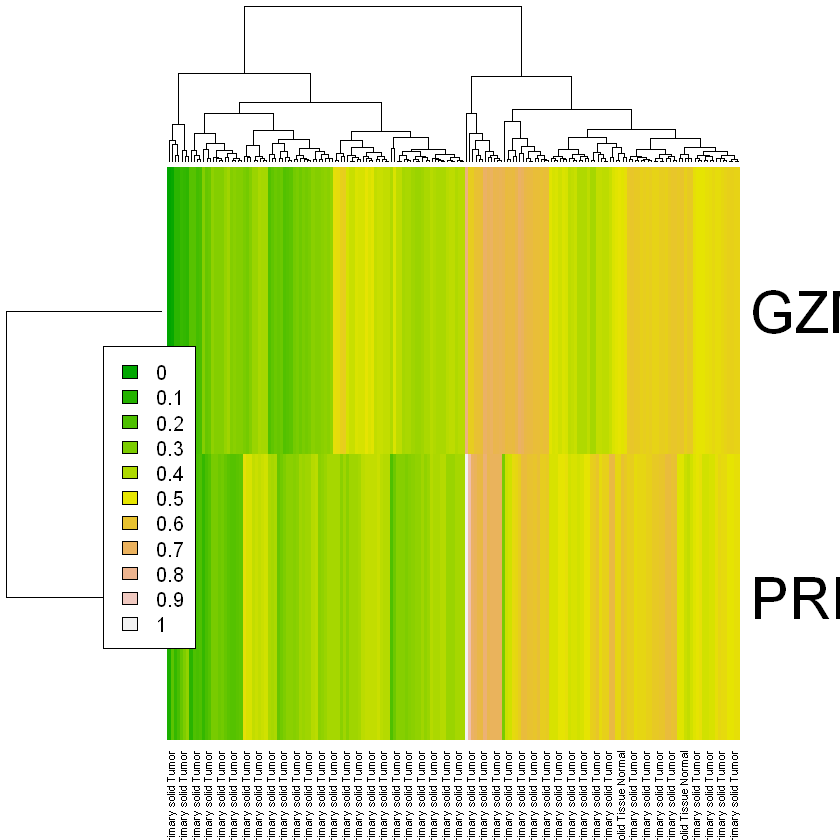

In [36]:
# Plot heat map
heatmap(t(as.matrix.data.frame(df_cyto_scaled)), scale="row", col = terrain.colors(256))
legend(x=0,y=0.6, legend=seq(from = 0,to = 1,by = 0.1),fill=colorRampPalette(colors = terrain.colors(256))(11))

In [ ]:
pl <- ggplot(dt2, aes(x = rowname, y = colname, fill = value)) + geom_tile(stat = )+ 
  scale_fill_viridis(discrete=FALSE)+
  theme(axis.text.x = element_blank())+xlab(label = 'Samples')+ylab(label = 'Genes')
print(pl)